In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
sns.set(style="whitegrid")

In [12]:
root = '/data0/lucy/ingroup_lang/'
path = root + 'logs/pmi/'

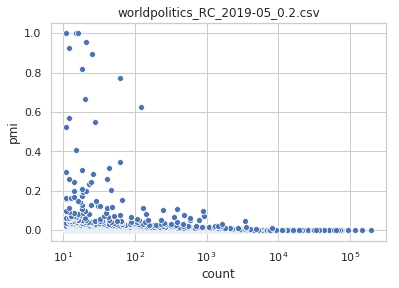

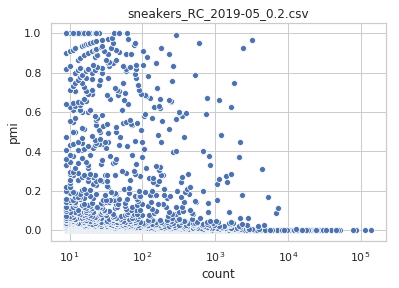

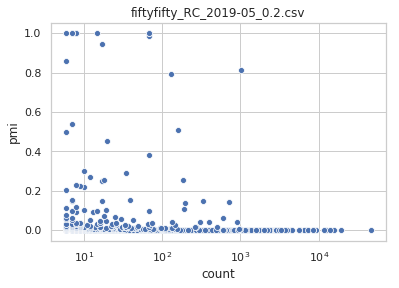

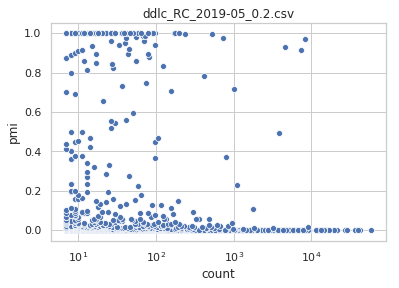

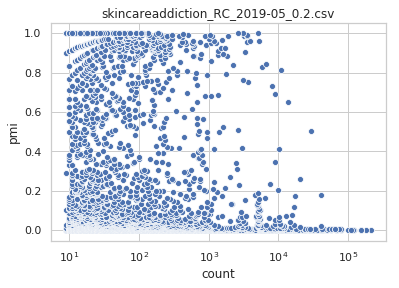

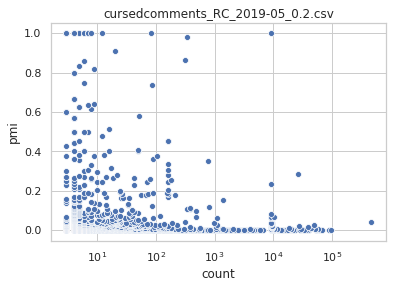

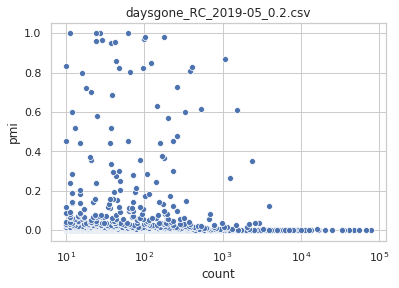

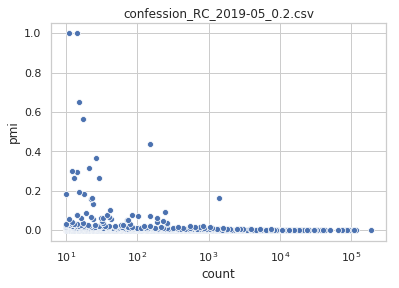

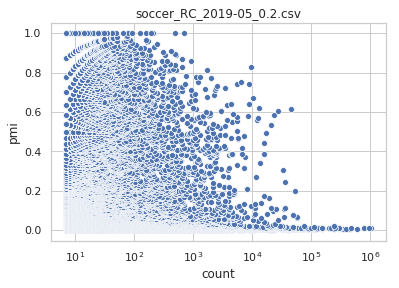

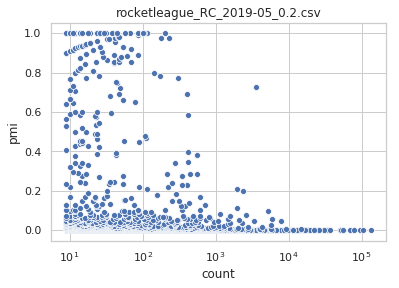

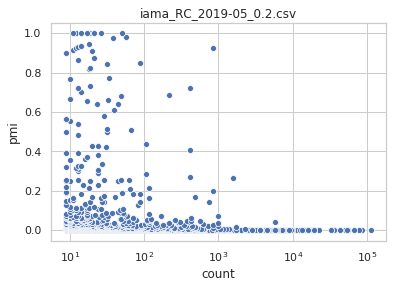

In [3]:
i = 0
for f in os.listdir(path): 
    if not f.endswith('.csv'): continue
    df = pd.read_csv(path + f, engine='python')
    p = sns.scatterplot(x='count', y='pmi', data=df)
    p.figure.get_axes()[0].set_xscale('log')
    plt.title(f)
    plt.show()
    i += 1
    if i > 10: break

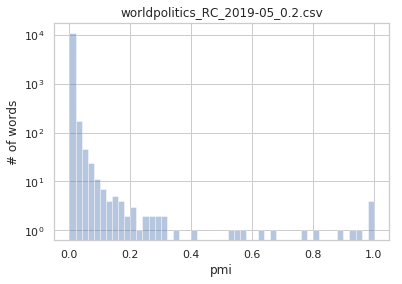

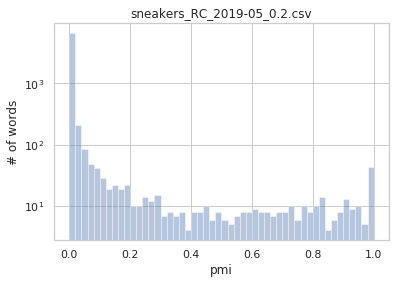

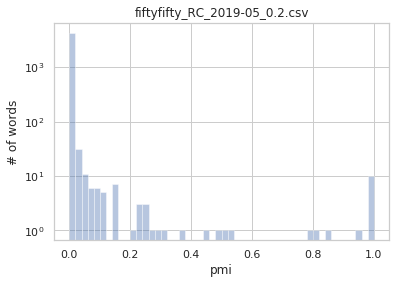

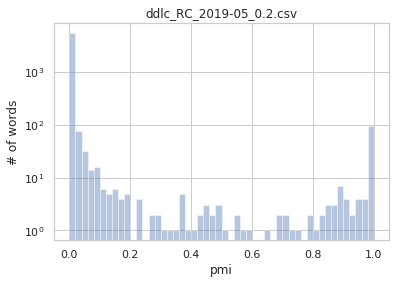

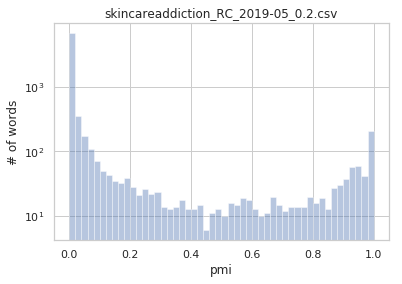

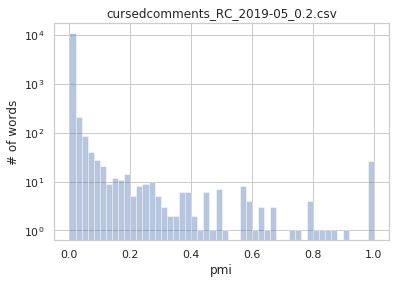

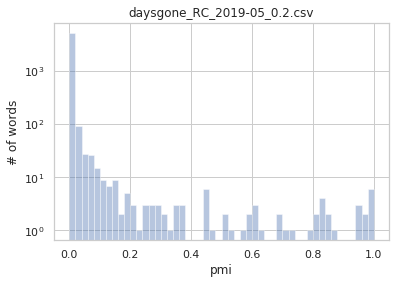

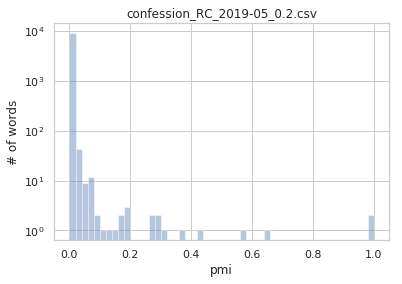

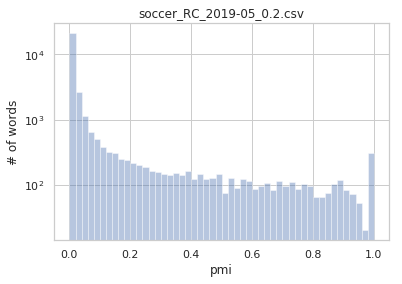

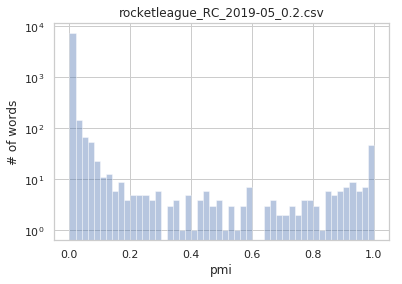

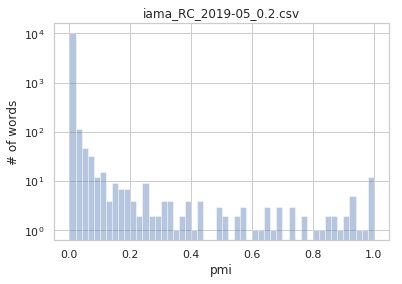

In [4]:
i = 0
for f in os.listdir(path): 
    if not f.endswith('.csv'): continue
    df = pd.read_csv(path + f, engine='python')
    p = sns.distplot(a=df['pmi'], kde=False)
    plt.yscale('log')
    plt.ylabel('# of words')
    plt.title(f)
    plt.show()
    i += 1
    if i > 10: break

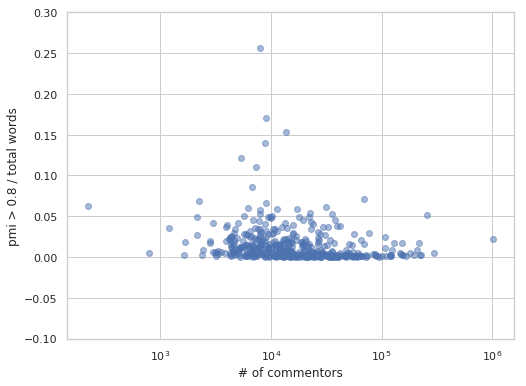

In [37]:
# number of words with pmi > 0.8 / total number of unique words (that occur with frequency > 20% in each subreddit)
# number of commenters
commentor_path = root + 'logs/commentor_counts/part-00000-f83d5d87-c50d-4d5a-a560-e978e85e0af8-c000.csv'
sr_ncoms = pd.read_csv(commentor_path, engine='python').set_index('subreddit').T.to_dict('list')
suffix = '_RC_2019-05_0.2.csv'
y = []
x = []
srs = []
for f in os.listdir(path): 
    if not f.endswith('.csv'): continue
    subreddit = f.replace(suffix, '')
    df = pd.read_csv(path + f, engine='python')
    num_words = len(df)
    high_pmi_df = df[df['pmi'] > 0.8]
    num_high_pmi = len(high_pmi_df)
    pmi_score = num_high_pmi / float(num_words)
    y.append(pmi_score)
    x.append(sr_ncoms[subreddit][0])
    srs.append(subreddit)
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5)
plt.xscale('log')
plt.ylabel('pmi > 0.8 / total words')
plt.xlabel('# of commentors')
plt.ylim(-0.1, 0.3)
plt.show()

In [32]:
for i, val in enumerate(y): 
    if val > 0.1: 
        print(srs[i], x[i], y[i])
# meme economy is entirely numbers
# market76 is full of user names
# hardwareswap is full of timestamps

('jailbreak', 13772, 0.15378620600077933)
('counting', 471, 0.4989648033126294)
('hardwareswap', 8999, 0.1706839409460681)
('rocketleagueexchange', 7415, 0.11073731426969442)
('market76', 7731, 0.3710906493094142)
('mechmarket', 5389, 0.1210843373493976)
('fakecollegefootball', 239, 0.31339285714285714)
('massivecock', 8050, 0.2556732223903177)
('memeeconomy', 17439, 0.6098360655737705)
('jobuds', 8849, 0.13956876456876458)


In [34]:
for i, val in enumerate(x): 
    if val < 1000: 
        print(srs[i], x[i], y[i])

('transcribersofreddit', 222, 0.062090854989089464)
('counting', 471, 0.4989648033126294)
('fakecollegefootball', 239, 0.31339285714285714)
('centerleftpolitics', 794, 0.005394693383243422)
